# Stocks
- 'AAPL', 'F', 'AMZN', 'GE', 'TSLA' 

In [1]:
import random
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 몇 가지 종목 코드(ticker)를 갖고 포트폴리오에 포함된 주식 리스트를 만든다
tickers = [ 'AAPL',  'AMZN', 'GE', 'TSLA' ] # 애플 포드 아마존 GE 테슬라

yf.pdr_override()

pxclose = pd.DataFrame( )

for item in tickers:
    pxclose[ item ] = web.get_data_yahoo(item, start='2019-01-01')[ 'Adj Close' ]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


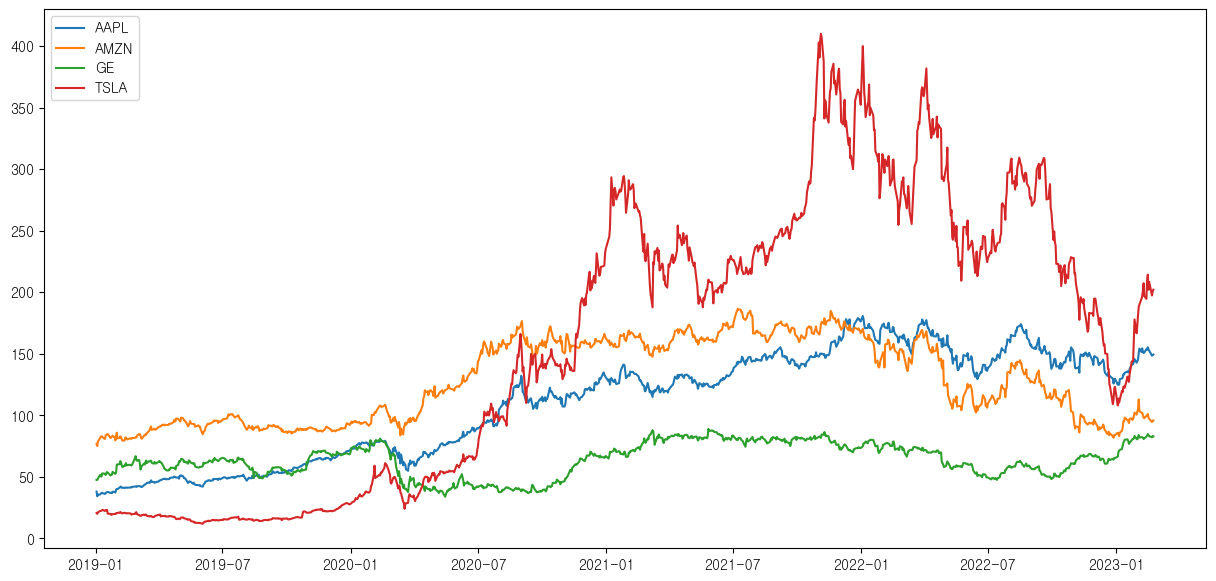

In [2]:
plt.figure(figsize=(15,7))
for i in tickers:
    plt.plot(pxclose.index,pxclose[i], label = i)
plt.legend(loc = 2)
plt.show();

In [3]:
ret_daily = pxclose.pct_change( )
ret_daily

,AAPL,AMZN,GE,TSLA
Date,,,,
2019-01-02,NaN,NaN,NaN,NaN
2019-01-03,-0.099607,-0.025241,0.001242,-0.031472
2019-01-04,0.042689,0.050064,0.021092,0.057697
2019-01-07,-0.002226,0.034353,0.061968,0.054361
2019-01-08,0.019063,0.016612,-0.020595,0.001164
...,...,...,...,...
2023-02-16,-0.010429,-0.029755,-0.008493,-0.056946
2023-02-17,-0.007547,-0.009679,-0.012017,0.031033
2023-02-21,-0.026680,-0.026955,-0.009393,-0.052518


### histogram

In [4]:
tickers

['AAPL', 'AMZN', 'GE', 'TSLA']

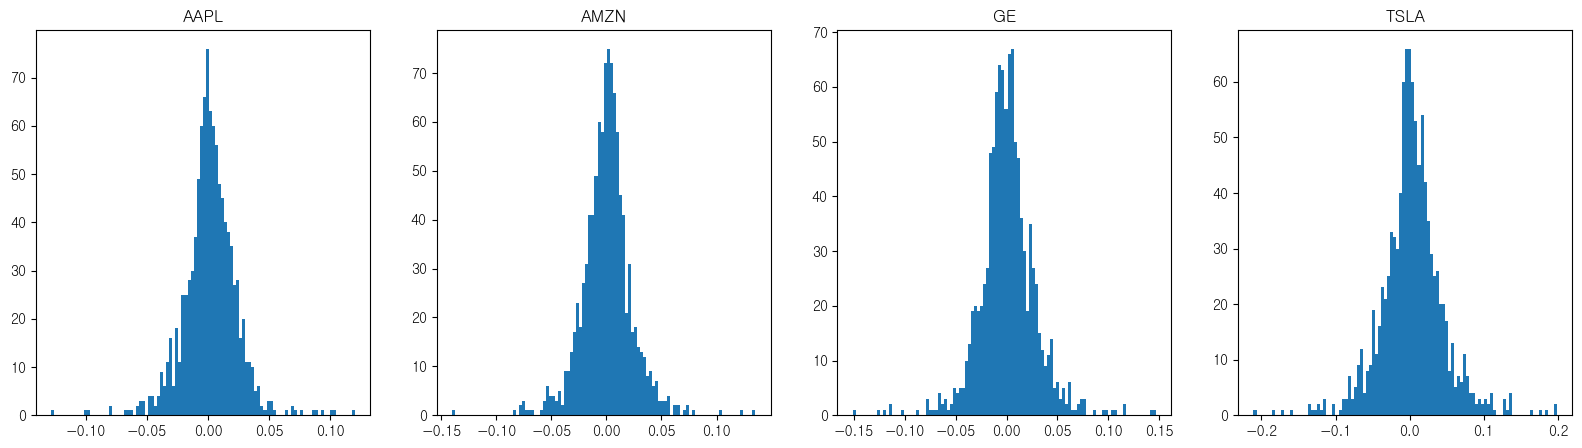

In [5]:
plt.figure(figsize=(25,5))

for i, t in enumerate(tickers):
    plt.subplot(151+i)
    plt.hist(ret_daily[t], bins=100)
    plt.title(t)

In [6]:
ret_daily_cs=ret_daily.cumsum()
ret_daily_cs

,AAPL,AMZN,GE,TSLA
Date,,,,
2019-01-02,NaN,NaN,NaN,NaN
2019-01-03,-0.099607,-0.025241,0.001242,-0.031472
2019-01-04,-0.056918,0.024823,0.022334,0.026226
2019-01-07,-0.059144,0.059176,0.084302,0.080587
2019-01-08,-0.040081,0.075788,0.063708,0.081751
...,...,...,...,...
2023-02-16,1.640409,0.511987,0.970063,3.222715
2023-02-17,1.632862,0.502308,0.958046,3.253748
2023-02-21,1.606182,0.475353,0.948653,3.201230


### cumsum time-series plot

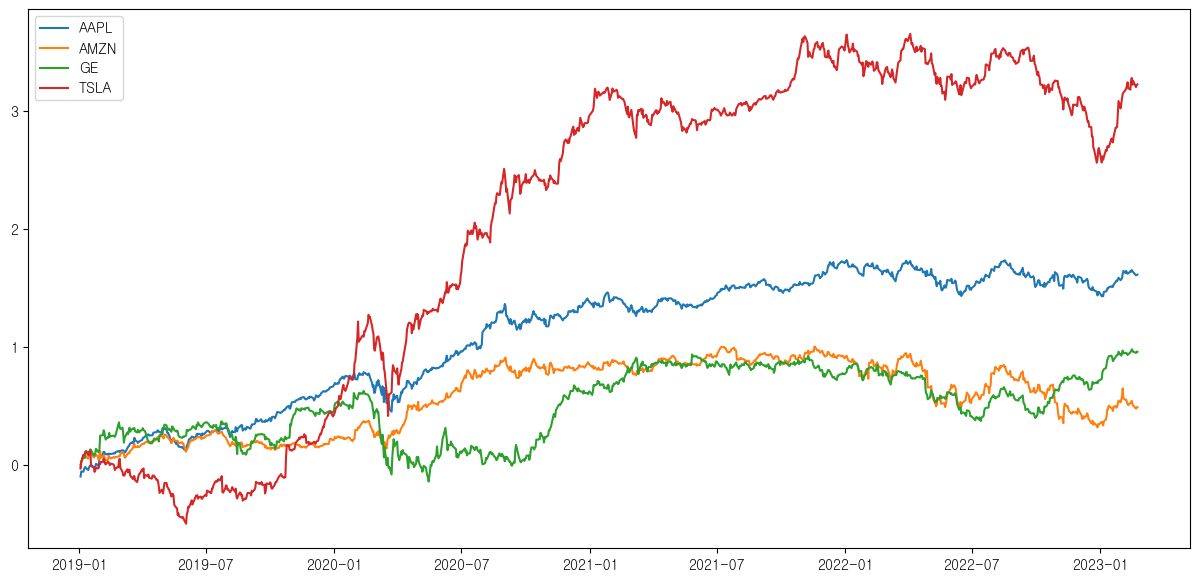

In [7]:
plt.figure(figsize=(15,7))
for i in tickers:
    plt.plot(ret_daily_cs.index,ret_daily_cs[i], label = i)
plt.legend(loc = 2)
plt.show();

- TSLA이 독보적으로 높은 cumsum을 가짐, 그 다음은 AAPL

# Optimize portfolio

In [8]:
ret_daily = pxclose.pct_change( )
ret_annual = ret_daily.mean( ) * 250

# 일간수익률의 공분산을 계산하고 연간 단위로 만든다
cov_daily = ret_daily.cov( )
cov_annual = cov_daily * 250

# risk-free rate: SOFR, policy rate
rf = 0.045

In [9]:
# 포트폴리오 수익률, 변동성, 투자 비중을 저장할 변수를 미리 준비한다
p_returns = []       # portfolio return
p_volatility = []      # portfolio risk
p_weights = []   # weights
sharpe_ratio = []   # sharpe ratio = return/risk
 
n_assets = len(tickers) # len( ) 함수로 투자자산의 수를 계산한다
n_ports = 30000 # 다섯 개 종목으로 투자 비중을 바꿔 3만 개의 포트폴리오를 만들 것이다

# n_ports만큼 반복하면서 자산의 투자 비중을 랜덤하게 만들고 포트폴리오의 기대수익률, 변동성을 계산한다
# 계산한 수익률, 변동성, 투자 비중은 앞서 미리 준비한 변수, p_returns, p_volatility, p_weights에 저장한다

for s in range( n_ports ):

    wgt = np.random.random( n_assets )
    wgt /= np.sum( wgt )
    ret = np.dot(wgt, ret_annual) - rf # excess return
    vol = np.sqrt( np.dot( wgt.T, np.dot( cov_annual, wgt ) ) )

    # append values to lists
    p_returns.append(ret)                    
    p_volatility.append(vol) 
    p_weights.append(wgt) 
    sharpe_ratio.append(ret/vol)  

In [10]:
# get dict of Retunrs, Risk, Sharpe, Weights
portfolio = {'Returns': p_returns, 'Risk': p_volatility, 'Sharpe' : sharpe_ratio}
for i, s in enumerate(tickers): 
    portfolio[s] = [wgt[i] for wgt in p_weights] 
    
# from dict to dataframe
df = pd.DataFrame(portfolio) 
df = df[['Returns', 'Risk','Sharpe'] + [s for s in tickers]] 

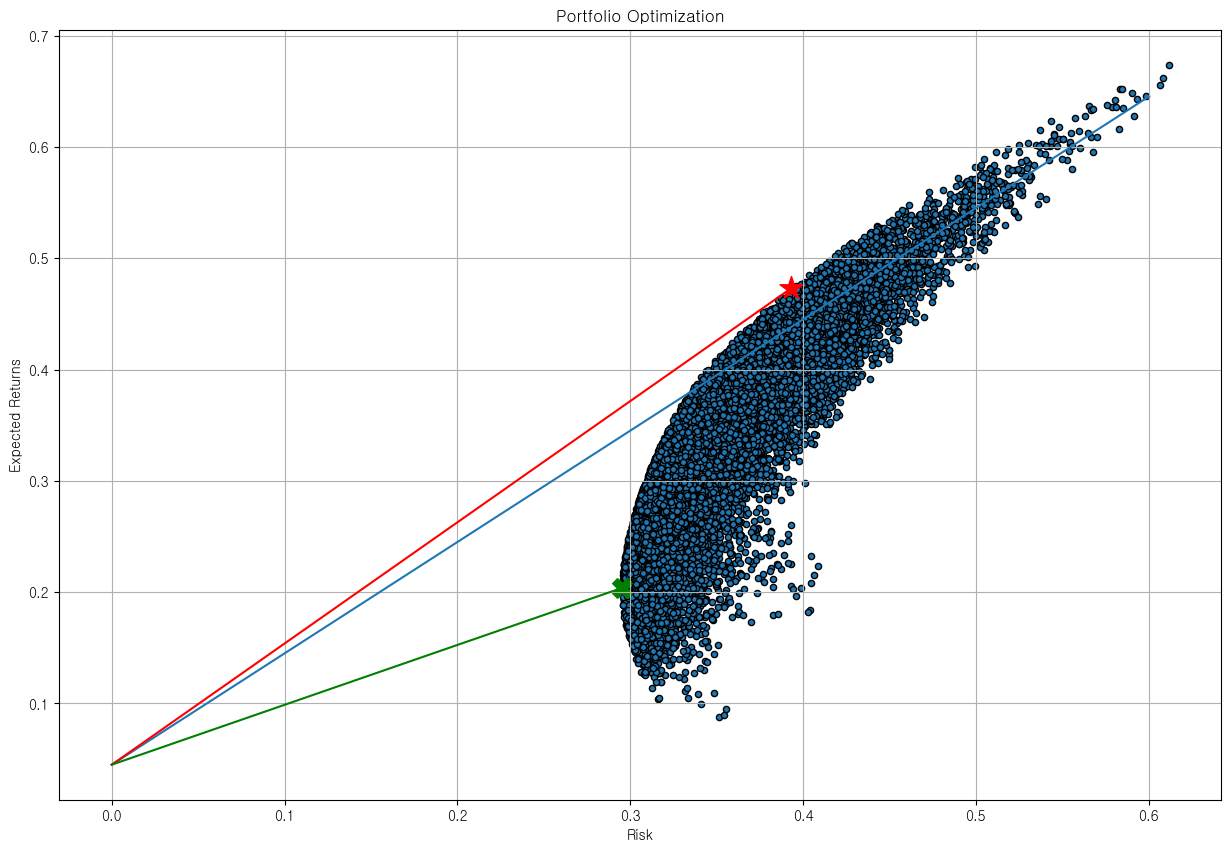

In [11]:
# Mean-Varinance portfolio : Maximum of Sharpe Ratio(tangent portfolio)
max_sharpe = df.loc[df['Sharpe'] ==df['Sharpe'].max()]

# Mininum-Variance portfolio : Minimum of Variance
min_risk = df.loc[df['Risk'] == df['Risk'].min()]

df.plot.scatter(x='Risk', y='Returns', #c='Sharpe', 
                cmap='viridis', edgecolors='k', 
                figsize=(15,10), grid=True) 

plt.scatter(x = max_sharpe['Risk'], y = max_sharpe['Returns'], 
            c ='r', marker='*', s = 300)       # Mean-Varinance portfolio: *
plt.scatter(x = min_risk['Risk'], y = min_risk['Returns'], 
            c = 'g', marker='X', s = 200)      # Mininum-Variance portfolio: X

plt.title('Portfolio Optimization') 
plt.xlabel('Risk') 
plt.ylabel('Expected Returns') 
# plt.ylim(0,0.3)
# plt.xlim(0,0.4)

plt.plot([0, 0.6], [rf, 0.6+rf])
plt.plot([0, max_sharpe['Risk'].values[0]], [rf, max_sharpe['Returns'].values[0]], color="r")
plt.plot([0, min_risk['Risk'].values[0]], [rf, min_risk['Returns'].values[0]], color="g")

plt.show();

In [12]:
# Mean-Varinance portfolio : Maximum of Sharpe Ratio(tangent portfolio)
max_sharpe = df.loc[df['Sharpe'] ==df['Sharpe'].max()]

# Mininum-Variance portfolio : Minimum of Variance
min_risk = df.loc[df['Risk'] == df['Risk'].min()]

In [13]:
max_sharpe

,Returns,Risk,Sharpe,AAPL,AMZN,GE,TSLA
23158,0.472838,0.393049,1.203002,0.651212,0.00335,0.002304,0.343134


- 시점 대비 높은 수익률을 보인 AAPL과 TSLA 비중이 높다

In [14]:
min_risk

,Returns,Risk,Sharpe,AAPL,AMZN,GE,TSLA
18545,0.203909,0.295515,0.690013,0.373435,0.359711,0.264533,0.002321


- 변동성이 가장 컷던 TSLA가 아주 낮은 weights를 가짐